In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/plant_village_dataset.zip"


/content/drive/MyDrive/plant_village_dataset.zip


In [ ]:
!unzip -q "/content/drive/MyDrive/plant_village_dataset.zip" -d "/content/data"


In [ ]:
!ls /content/data


'plantvillage dataset'


In [ ]:

!ls "/content/data/plantvillage dataset"


color  grayscale  segmented


In [ ]:
!ls "/content/data/plantvillage dataset/color"


 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [ ]:
data_dir = "/content/data/plantvillage dataset/color"


In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

print("Total images:", len(dataset))
print("Classes:", len(dataset.classes))
print("Example class names:", dataset.classes[:10])


Total images: 54305
Classes: 38
Example class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)



Device: cuda


In [ ]:

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load full dataset with train transform for now
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

print("Total images:", len(full_dataset))
print("Number of classes:", len(full_dataset.classes))
print("First 10 class names:", full_dataset.classes[:10])


Total images: 54305
Number of classes: 38
First 10 class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


In [ ]:
#plit into train / val / test and create loaders

from torch.utils.data import random_split, DataLoader

torch.manual_seed(42)  # reproducibility

n_total = len(full_dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [n_train, n_val, n_test]
)

# use non-augmented transform for val + test
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

print(len(train_dataset), len(val_dataset), len(test_dataset))


38013 8145 8147


In [ ]:
#Define the CNN model (ResNet18)

num_classes = len(full_dataset.classes)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # replace last layer

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [ ]:
#Training and validation loops
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 10

for epoch in range(num_epochs):
    start = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_model(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end = time.time()
    epoch_time = (end - start) / 60

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.0459, Acc: 0.9862
Epoch 2/10 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0172, Acc: 0.9957
Epoch 3/10 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0192, Acc: 0.9959
Epoch 4/10 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0286, Acc: 0.9920
Epoch 5/10 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0245, Acc: 0.9930
Epoch 6/10 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0322, Acc: 0.9923
Epoch 7/10 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0250, Acc: 0.9925
Epoch 8/10 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.0137, Acc: 0.9959
Epoch 9/10 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0131, Acc: 0.9963
Epoch 10/10 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0146, Acc: 0.9973


In [ ]:
test_loss, test_acc = eval_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0107, Test Accuracy: 0.9972


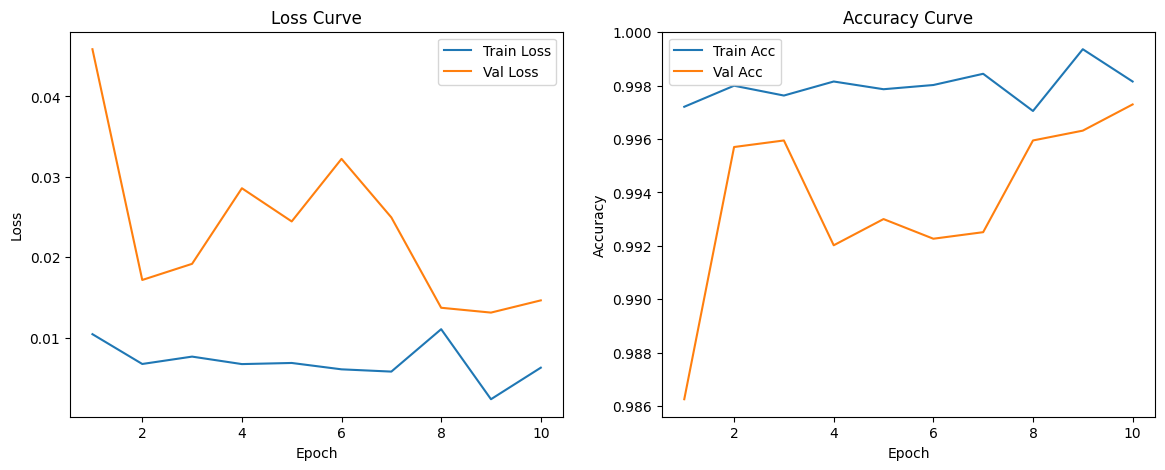

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14,5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [ ]:
model.eval()
images, labels = next(iter(test_loader))
images = images[:8].to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

print("Predicted:", preds.cpu().numpy())
print("Actual:", labels[:8].numpy())


Predicted: [ 4 16 24 35 27  6 34 24]
Actual: [ 4 16 24 35 27  6 34 24]


In [ ]:
torch.save(model.state_dict(), "plant_cnn_resnet18.pth")
print("Model saved as plant_cnn_resnet18.pth")


Model saved as plant_cnn_resnet18.pth


FUZZY LOGIC


In [ ]:
!pip install -q scikit-fuzzy opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 24.0 MB/s eta 0:00:00


In [ ]:
import numpy as np

classes = full_dataset.classes
print("Number of classes:", len(classes))

# all indices whose class name contains "healthy"
healthy_indices = [i for i, name in enumerate(classes) if "healthy" in name.lower()]
print("Healthy indices:", healthy_indices)
print("Healthy class names:", [classes[i] for i in healthy_indices])


Number of classes: 38
Healthy indices: [3, 4, 6, 10, 14, 17, 19, 22, 23, 24, 27, 37]
Healthy class names: ['Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___healthy', 'Grape___healthy', 'Peach___healthy', 'Pepper,_bell___healthy', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Strawberry___healthy', 'Tomato___healthy']


In [ ]:
# test_dataset is a Subset of full_dataset
test_indices = test_dataset.indices        # indices into full_dataset
test_paths   = [full_dataset.samples[i][0] for i in test_indices]
test_labels  = [full_dataset.samples[i][1] for i in test_indices]
len(test_paths), len(test_labels)


(8147, 8147)

In [ ]:
model.eval()
cnn_results = []

idx = 0  # index in test_paths

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = F.softmax(logits, dim=1).cpu().numpy()

        # healthy prob = sum over all healthy classes
        p_healthy = probs[:, healthy_indices].sum(axis=1)
        p_disease = 1.0 - p_healthy

        batch_size = images.size(0)
        for i in range(batch_size):
            cnn_results.append({
                "path": test_paths[idx],
                "true_label": int(test_labels[idx]),
                "p_healthy": float(p_healthy[i]),
                "p_disease": float(p_disease[i]),
            })
            idx += 1

len(cnn_results), cnn_results[0]


(8147,
 {'path': '/content/data/plantvillage dataset/color/Blueberry___healthy/eb8a1b90-4be0-4cb3-89a8-1338adc9fea7___RS_HL 0664.JPG',
  'true_label': 4,
  'p_healthy': 1.0,
  'p_disease': 0.0})

In [ ]:
import cv2
import numpy as np

def lesion_area_ratio(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return 0.0

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Approximate leaf region (greenish)
    lower_leaf = np.array([25, 40, 40])
    upper_leaf = np.array([90, 255, 255])
    leaf_mask = cv2.inRange(hsv, lower_leaf, upper_leaf)

    # Lesions: dark + brown/yellow
    lower_lesion1 = np.array([0, 0, 0])      # dark
    upper_lesion1 = np.array([180, 255, 80])

    lower_lesion2 = np.array([5, 50, 50])    # brown / yellow
    upper_lesion2 = np.array([30, 255, 255])

    mask1 = cv2.inRange(hsv, lower_lesion1, upper_lesion1)
    mask2 = cv2.inRange(hsv, lower_lesion2, upper_lesion2)
    lesion_mask = cv2.bitwise_or(mask1, mask2)

    # Restrict lesions to leaf region
    lesion_on_leaf = cv2.bitwise_and(lesion_mask, lesion_mask, mask=leaf_mask)

    lesion_pixels = np.count_nonzero(lesion_on_leaf)
    leaf_pixels   = np.count_nonzero(leaf_mask)

    if leaf_pixels == 0:
        return 0.0

    return lesion_pixels / leaf_pixels


In [ ]:
def estimate_healthy_lab_mean(healthy_paths, max_samples=50):
    labs = []
    for p in healthy_paths[:max_samples]:
        img = cv2.imread(p)
        if img is None:
            continue
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        labs.append(lab.reshape(-1, 3).mean(axis=0))
    if not labs:
        # fallback
        return np.array([150, 120, 120], dtype=np.float32)
    return np.mean(labs, axis=0)

# collect all healthy image paths from the full dataset
healthy_paths_all = [
    path for path, label in full_dataset.samples
    if "healthy" in classes[label].lower()
]

ref_lab = estimate_healthy_lab_mean(healthy_paths_all, max_samples=100)
print("Reference healthy LAB mean:", ref_lab)


Reference healthy LAB mean: [121.90761566 125.3565184  127.0426178 ]


In [ ]:
def color_deviation(img_path, ref_lab, max_dist=80.0):
    img = cv2.imread(img_path)
    if img is None:
        return 0.0

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    mean_lab = lab.reshape(-1, 3).mean(axis=0)

    dist = np.linalg.norm(mean_lab - ref_lab)

    # normalize to 0–1
    return float(min(dist / max_dist, 1.0))


In [ ]:
for item in cnn_results:
    l_ratio = lesion_area_ratio(item["path"])
    c_dev   = color_deviation(item["path"], ref_lab)

    item["lesion_ratio"] = l_ratio
    item["color_dev"]    = c_dev

# quick look
cnn_results[0]


{'path': '/content/data/plantvillage dataset/color/Blueberry___healthy/eb8a1b90-4be0-4cb3-89a8-1338adc9fea7___RS_HL 0664.JPG',
 'true_label': 4,
 'p_healthy': 1.0,
 'p_disease': 0.0,
 'lesion_ratio': 0.2170493865995596,
 'color_dev': 0.3382596142065339}

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Inputs
p_disease = ctrl.Antecedent(np.linspace(0, 1, 101), 'p_disease')
lesion    = ctrl.Antecedent(np.linspace(0, 1, 101), 'lesion')
color_dev = ctrl.Antecedent(np.linspace(0, 1, 101), 'color_dev')

# Output
health_score = ctrl.Consequent(np.linspace(0, 1, 101), 'health_score')

# Membership functions
p_disease['low']  = fuzz.trimf(p_disease.universe, [0, 0, 0.4])
p_disease['med']  = fuzz.trimf(p_disease.universe, [0.2, 0.5, 0.8])
p_disease['high'] = fuzz.trimf(p_disease.universe, [0.6, 1, 1])

lesion['small']   = fuzz.trimf(lesion.universe, [0, 0, 0.3])
lesion['medium']  = fuzz.trimf(lesion.universe, [0.1, 0.5, 0.8])
lesion['large']   = fuzz.trimf(lesion.universe, [0.6, 1, 1])

color_dev['mild']      = fuzz.trimf(color_dev.universe, [0, 0, 0.3])
color_dev['moderate']  = fuzz.trimf(color_dev.universe, [0.1, 0.5, 0.8])
color_dev['severe']    = fuzz.trimf(color_dev.universe, [0.6, 1, 1])

health_score['low']    = fuzz.trimf(health_score.universe, [0, 0, 0.4])   # healthy
health_score['medium'] = fuzz.trimf(health_score.universe, [0.2, 0.5, 0.8])
health_score['high']   = fuzz.trimf(health_score.universe, [0.6, 1, 1])   # severely diseased


In [ ]:
rule1 = ctrl.Rule(
    p_disease['low'] & lesion['small'] & color_dev['mild'],
    health_score['low']
)

rule2 = ctrl.Rule(
    p_disease['high'] & lesion['large'] & color_dev['severe'],
    health_score['high']
)

rule3 = ctrl.Rule(
    p_disease['med'] & lesion['medium'],
    health_score['medium']
)

rule4 = ctrl.Rule(
    p_disease['high'] & (lesion['medium'] | color_dev['moderate']),
    health_score['high']
)

rule5 = ctrl.Rule(
    p_disease['low'] & (lesion['large'] | color_dev['severe']),
    health_score['medium']
)

rule6 = ctrl.Rule(
    p_disease['med'] & lesion['small'] & color_dev['mild'],
    health_score['medium']
)

health_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])


In [ ]:
def compute_health_score(p_d, l_ratio, c_dev):
    sim = ctrl.ControlSystemSimulation(health_ctrl)
    sim.input['p_disease'] = float(p_d)
    sim.input['lesion']    = float(l_ratio)
    sim.input['color_dev'] = float(c_dev)
    sim.compute()
    return float(sim.output['health_score'])


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Define input variables
p_disease = ctrl.Antecedent(np.linspace(0, 1, 101), 'p_disease')
lesion    = ctrl.Antecedent(np.linspace(0, 1, 101), 'lesion')
color_dev = ctrl.Antecedent(np.linspace(0, 1, 101), 'color_dev')

# 2. Define output variable  (IMPORTANT: name must be 'health_score')
health_score = ctrl.Consequent(np.linspace(0, 1, 101), 'health_score')

# 3. Membership functions
p_disease['low']  = fuzz.trimf(p_disease.universe, [0, 0, 0.4])
p_disease['med']  = fuzz.trimf(p_disease.universe, [0.2, 0.5, 0.8])
p_disease['high'] = fuzz.trimf(p_disease.universe, [0.6, 1, 1])

lesion['small']   = fuzz.trimf(lesion.universe, [0, 0, 0.3])
lesion['medium']  = fuzz.trimf(lesion.universe, [0.1, 0.5, 0.8])
lesion['large']   = fuzz.trimf(lesion.universe, [0.6, 1, 1])

color_dev['mild']      = fuzz.trimf(color_dev.universe, [0, 0, 0.3])
color_dev['moderate']  = fuzz.trimf(color_dev.universe, [0.1, 0.5, 0.8])
color_dev['severe']    = fuzz.trimf(color_dev.universe, [0.6, 1, 1])

health_score['low']    = fuzz.trimf(health_score.universe, [0, 0, 0.4])
health_score['medium'] = fuzz.trimf(health_score.universe, [0.2, 0.5, 0.8])
health_score['high']   = fuzz.trimf(health_score.universe, [0.6, 1, 1])

# 4. Fuzzy rules
rule1 = ctrl.Rule(
    p_disease['low'] & lesion['small'] & color_dev['mild'],
    health_score['low']
)

rule2 = ctrl.Rule(
    p_disease['high'] & lesion['large'] & color_dev['severe'],
    health_score['high']
)

rule3 = ctrl.Rule(
    p_disease['med'] & lesion['medium'],
    health_score['medium']
)

rule4 = ctrl.Rule(
    p_disease['high'] & (lesion['medium'] | color_dev['moderate']),
    health_score['high']
)

rule5 = ctrl.Rule(
    p_disease['low'] & (lesion['large'] | color_dev['severe']),
    health_score['medium']
)

rule6 = ctrl.Rule(
    p_disease['med'] & lesion['small'] & color_dev['mild'],
    health_score['medium']
)

# 5. Build control system
health_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])


In [ ]:
sim = ctrl.ControlSystemSimulation(health_ctrl)
sim.input['p_disease'] = 0.9
sim.input['lesion']    = 0.8
sim.input['color_dev'] = 0.7
sim.compute()

print("Fuzzy outputs dict:", sim.output)


Fuzzy outputs dict: {'health_score': np.float64(0.8311111111111107)}


In [ ]:
def compute_health_score(p_d, l_ratio, c_dev):
    sim = ctrl.ControlSystemSimulation(health_ctrl)
    sim.input['p_disease'] = float(p_d)
    sim.input['lesion']    = float(l_ratio)
    sim.input['color_dev'] = float(c_dev)

    try:
        sim.compute()
    except Exception as e:
        # If scikit-fuzzy fails internally, fall back to a neutral score
        # (you can log or print if you want to debug)
        # print("Fuzzy error:", e, "inputs:", p_d, l_ratio, c_dev)
        return 0.5

    # Sometimes sim.output may not contain 'health_score' due to numerical issues
    if 'health_score' in sim.output:
        return float(sim.output['health_score'])
    else:
        # Fallback: simple average of the three indicators as a neutral estimate
        # so your code doesn't crash
        return float((p_d + l_ratio + c_dev) / 3.0)


In [ ]:
for item in cnn_results:
    item["health_score"] = compute_health_score(
        item["p_disease"],
        item["lesion_ratio"],
        item["color_dev"]
    )

for i in range(5):
    print("Image:", cnn_results[i]["path"])
    print("  p_disease :", cnn_results[i]["p_disease"])
    print("  lesion    :", cnn_results[i]["lesion_ratio"])
    print("  color_dev :", cnn_results[i]["color_dev"])
    print("  health_sc :", cnn_results[i]["health_score"])
    print()


Image: /content/data/plantvillage dataset/color/Blueberry___healthy/eb8a1b90-4be0-4cb3-89a8-1338adc9fea7___RS_HL 0664.JPG
  p_disease : 0.0
  lesion    : 0.2170493865995596
  color_dev : 0.3382596142065339
  health_sc : 0.18510300026869783

Image: /content/data/plantvillage dataset/color/Peach___Bacterial_spot/b96d6d11-4828-4e70-b760-3b8c997bfbf4___Rutg._Bact.S 1860.JPG
  p_disease : 0.9999997019767761
  lesion    : 0.7882049074472665
  color_dev : 0.10138237333142133
  health_sc : 0.803905417142875

Image: /content/data/plantvillage dataset/color/Soybean___healthy/e7495934-65df-4642-a7bb-53c4193e2ba8___RS_HL 5661 1.JPG
  p_disease : 0.0
  lesion    : 0.027220243213364453
  color_dev : 0.35451229701366044
  health_sc : 0.12724418007567498

Image: /content/data/plantvillage dataset/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/db4d97fa-700b-457f-a05f-1e1cf22bf88f___YLCV_NREC 2903.JPG
  p_disease : 1.0
  lesion    : 0.5007395720343162
  color_dev : 0.2184795780995045
  health_sc : 0.86666

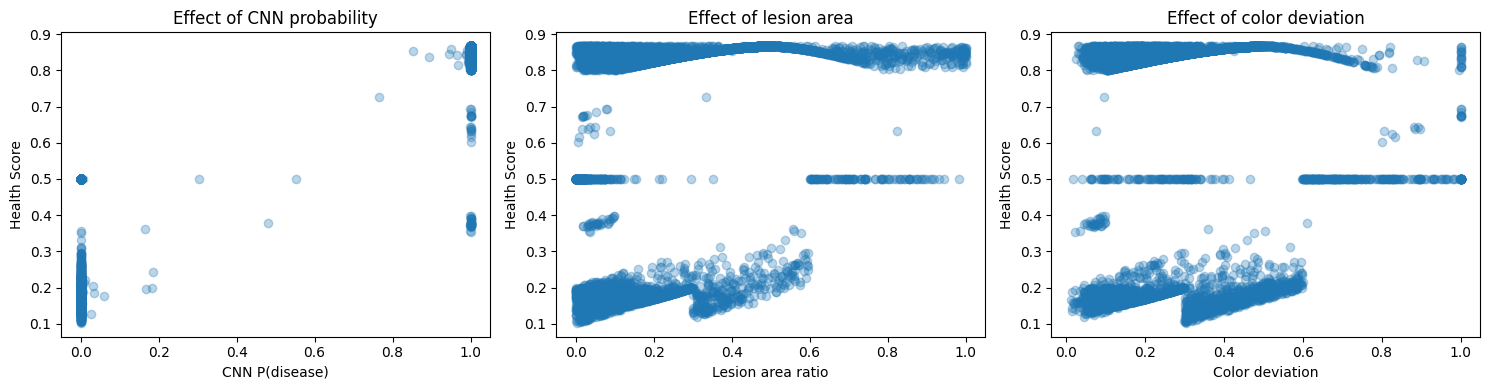

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(cnn_results)

plt.figure(figsize=(15,4))

# -------- 1. Effect of CNN Probability --------
plt.subplot(1,3,1)
plt.scatter(df["p_disease"], df["health_score"], alpha=0.3)
plt.xlabel("CNN P(disease)")
plt.ylabel("Health Score")
plt.title("Effect of CNN probability")

# -------- 2. Effect of Lesion Area --------
plt.subplot(1,3,2)
plt.scatter(df["lesion_ratio"], df["health_score"], alpha=0.3)
plt.xlabel("Lesion area ratio")
plt.ylabel("Health Score")
plt.title("Effect of lesion area")

# -------- 3. Effect of Color Deviation --------
plt.subplot(1,3,3)
plt.scatter(df["color_dev"], df["health_score"], alpha=0.3)
plt.xlabel("Color deviation")
plt.ylabel("Health Score")
plt.title("Effect of color deviation")

plt.tight_layout()
plt.show()


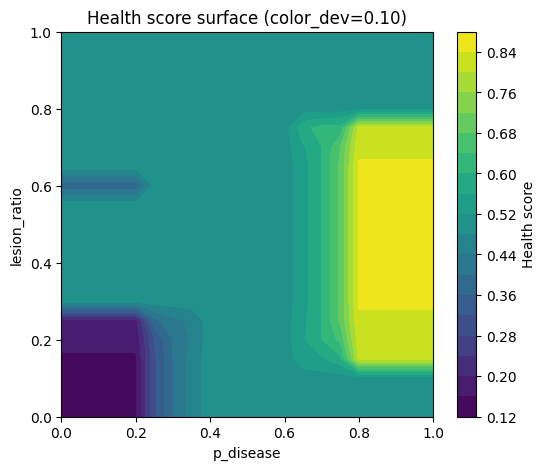

In [ ]:
import numpy as np
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

def health_surface(fixed_color=0.3, resolution=21):
    xs = np.linspace(0, 1, resolution)   # p_disease
    ys = np.linspace(0, 1, resolution)   # lesion
    Z  = np.zeros((resolution, resolution))

    for i, p_d in enumerate(xs):
        for j, l in enumerate(ys):
            sim = ctrl.ControlSystemSimulation(health_ctrl)
            sim.input['p_disease'] = float(p_d)
            sim.input['lesion']    = float(l)
            sim.input['color_dev'] = float(fixed_color)
            sim.compute()
            Z[j, i] = sim.output.get('health_score', 0.5)

    X, Y = np.meshgrid(xs, ys)
    plt.figure(figsize=(6,5))
    cp = plt.contourf(X, Y, Z, levels=20)
    plt.colorbar(cp, label="Health score")
    plt.xlabel("p_disease")
    plt.ylabel("lesion_ratio")
    plt.title(f"Health score surface (color_dev={fixed_color:.2f})")
    plt.show()

health_surface(fixed_color=0.1)


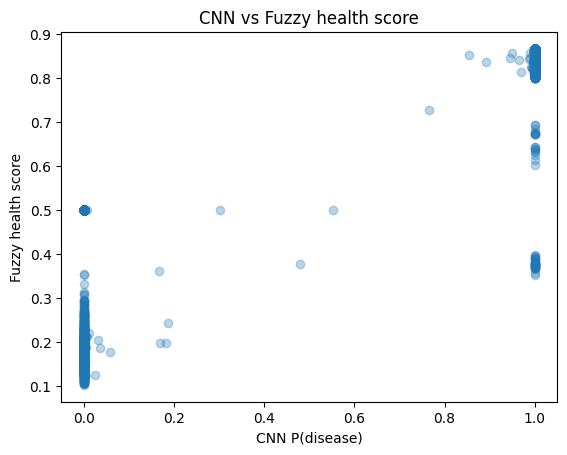

Correlation between CNN prob and fuzzy health score: 0.968439674698457


In [ ]:
plt.scatter(df["p_disease"], df["health_score"], alpha=0.3)
plt.xlabel("CNN P(disease)")
plt.ylabel("Fuzzy health score")
plt.title("CNN vs Fuzzy health score")
plt.show()

corr = df["p_disease"].corr(df["health_score"])
print("Correlation between CNN prob and fuzzy health score:", corr)


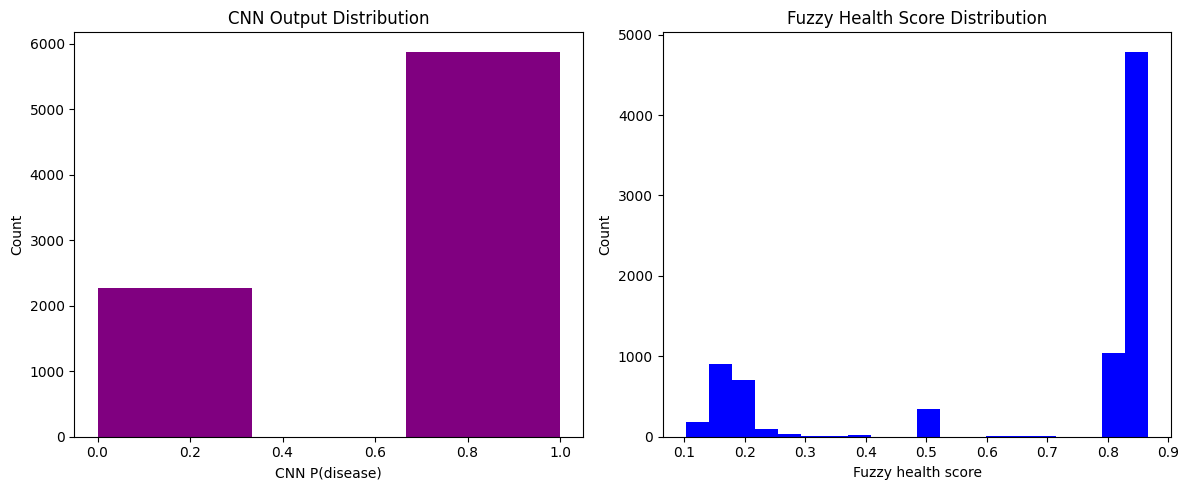

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df["p_disease"], bins=3, color="purple")
plt.title("CNN Output Distribution")
plt.xlabel("CNN P(disease)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(df["health_score"], bins=20, color="blue")
plt.title("Fuzzy Health Score Distribution")
plt.xlabel("Fuzzy health score")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


/tmp/ipython-input-2573722777.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["p_disease"], df["health_score"]], labels=["CNN", "Fuzzy"])


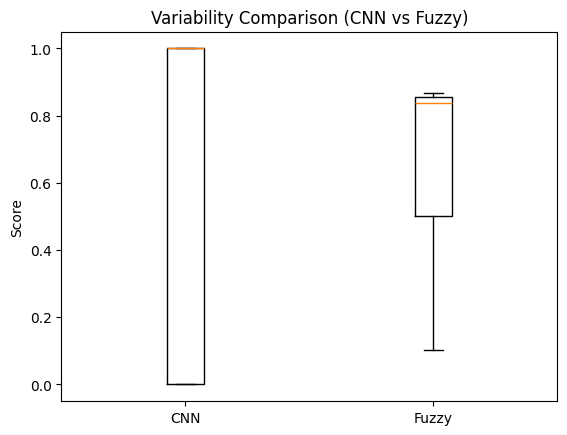

In [ ]:
plt.boxplot([df["p_disease"], df["health_score"]], labels=["CNN", "Fuzzy"])
plt.title("Variability Comparison (CNN vs Fuzzy)")
plt.ylabel("Score")
plt.show()


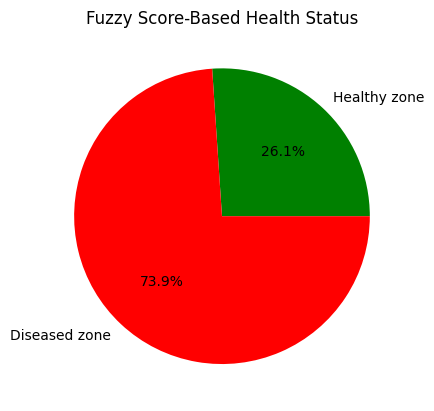

In [ ]:
high_severity = (df["health_score"] > 0.5).sum()
low_severity = (df["health_score"] <= 0.5).sum()

plt.pie([low_severity, high_severity],
        labels=["Healthy zone", "Diseased zone"],
        autopct='%1.1f%%',
        colors=["green", "red"])

plt.title("Fuzzy Score-Based Health Status")
plt.show()


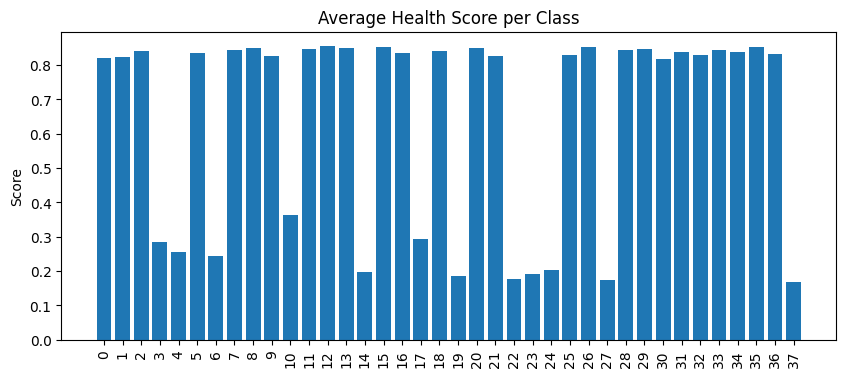

In [ ]:
class_scores = df.groupby("true_label")["health_score"].mean()
plt.figure(figsize=(10,4))
plt.bar(range(len(class_scores)), class_scores)
plt.xticks(range(len(class_scores)), class_scores.index, rotation=90)
plt.title("Average Health Score per Class")
plt.ylabel("Score")
plt.show()


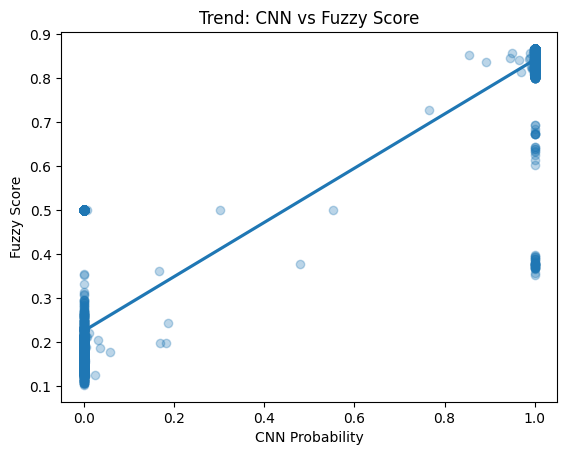

In [ ]:
import seaborn as sns

sns.regplot(x=df["p_disease"], y=df["health_score"], scatter_kws={'alpha':0.3})
plt.title("Trend: CNN vs Fuzzy Score")
plt.xlabel("CNN Probability")
plt.ylabel("Fuzzy Score")
plt.show()


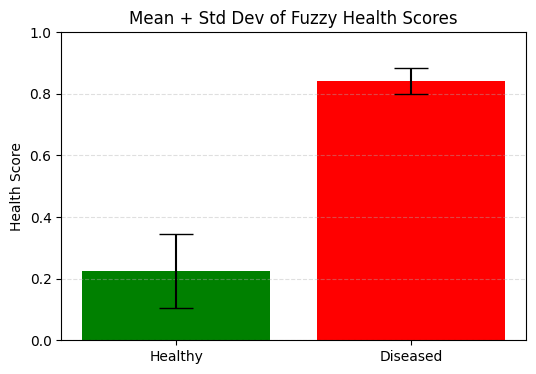

In [ ]:
stats = df.groupby("is_healthy")["health_score"].agg(["mean", "std"])

healthy_mean  = stats.loc[True, "mean"]
healthy_std   = stats.loc[True, "std"]
diseased_mean = stats.loc[False, "mean"]
diseased_std  = stats.loc[False, "std"]

plt.figure(figsize=(6,4))
plt.bar(
    ["Healthy", "Diseased"],
    [healthy_mean, diseased_mean],
    yerr=[healthy_std, diseased_std],
    capsize=12,
    color=["green", "red"]
)

plt.title("Mean + Std Dev of Fuzzy Health Scores")
plt.ylabel("Health Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


Mean health score (healthy classes): 0.22568532158325533
Mean health score (diseased classes): 0.8414246973087034


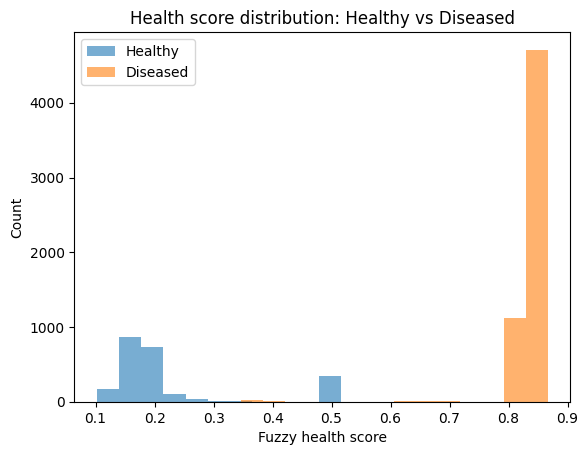

In [ ]:
# mark healthy vs diseased based on true_label names
class_names = full_dataset.classes
is_healthy_class = [("healthy" in name.lower()) for name in class_names]

df["is_healthy"] = df["true_label"].apply(lambda idx: is_healthy_class[idx])

healthy_scores  = df[df["is_healthy"]]["health_score"]
diseased_scores = df[~df["is_healthy"]]["health_score"]

print("Mean health score (healthy classes):", healthy_scores.mean())
print("Mean health score (diseased classes):", diseased_scores.mean())

plt.hist(healthy_scores, bins=20, alpha=0.6, label="Healthy")
plt.hist(diseased_scores, bins=20, alpha=0.6, label="Diseased")
plt.xlabel("Fuzzy health score")
plt.ylabel("Count")
plt.title("Health score distribution: Healthy vs Diseased")
plt.legend()
plt.show()


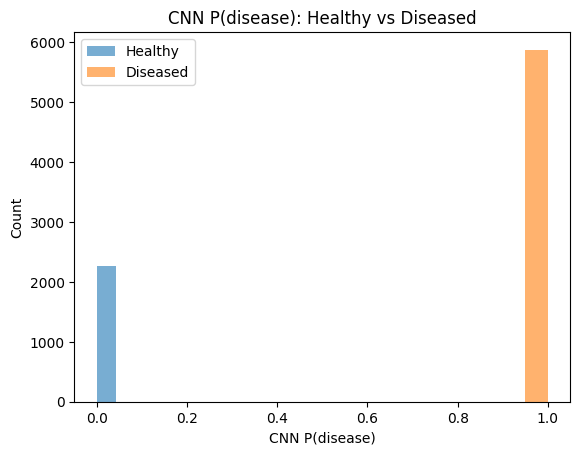

In [ ]:
healthy_pd  = df[df["is_healthy"]]["p_disease"]
diseased_pd = df[~df["is_healthy"]]["p_disease"]

plt.hist(healthy_pd, bins=20, alpha=0.6, label="Healthy")
plt.hist(diseased_pd, bins=20, alpha=0.6, label="Diseased")
plt.xlabel("CNN P(disease)")
plt.ylabel("Count")
plt.title("CNN P(disease): Healthy vs Diseased")
plt.legend()
plt.show()
